In [1]:
import re
import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Banglish EDA.csv',encoding= 'unicode_escape')

In [3]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
df["labels"] = lb_make.fit_transform(df["Emotion"])
df[["Emotion", "labels"]].head(11)


,Emotion,labels
0,sad,4
1,angry,0
2,disgust,1
3,angry,0
4,disgust,1
5,sad,4
6,sad,4
7,fear,2
8,surprise,5
9,disgust,1


In [4]:
test_df=df.sample(frac=0.2,random_state=200)
train_df=df.drop(test_df.index)

In [5]:
train_df.head()

,Emotion,text,labels
0,sad,hefajoter pokkhe michil theke hamlay ahoto awa...,4
1,angry,e chara mask chara probesh korte dicchi na,0
2,disgust,vore uthe batch porano college e class neya ab...,1
3,angry,eita pata chagler kach,0
4,disgust,sob dalal diye vore geche!,1


In [6]:
#checking for ull values
train_df.info()
print()
test_df.info()
print()
#val_df.info()
#print()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6089 entries, 0 to 7610
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Emotion  6089 non-null   object
 1   text     6089 non-null   object
 2   labels   6089 non-null   int32 
dtypes: int32(1), object(2)
memory usage: 166.5+ KB

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1522 entries, 6942 to 5208
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Emotion  1522 non-null   object
 1   text     1522 non-null   object
 2   labels   1522 non-null   int32 
dtypes: int32(1), object(2)
memory usage: 41.6+ KB



In [7]:
train_df["Emotion"].value_counts()

surprise    1090
happy       1043
sad         1024
angry       1004
disgust      972
fear         956
Name: Emotion, dtype: int64

In [8]:
test_df["Emotion"].value_counts()

fear        275
angry       268
sad         264
happy       262
surprise    229
disgust     224
Name: Emotion, dtype: int64

In [9]:
#sample text from dataset
sample = train_df["text"]
print(sample)

0       hefajoter pokkhe michil theke hamlay ahoto awa...
1              e chara mask chara probesh korte dicchi na
2       vore uthe batch porano college e class neya ab...
3                                  eita pata chagler kach
4                              sob dalal diye vore geche!
                              ...                        
7602    destite mot 1 lakh 68 hajar 436 joner mirttu h...
7603    jatiy bishowbiddaloyer cturhhotoh borsh porikk...
7607                              amar oporadh ami hindu 
7608    apnara kiser zukti niye bolechen amar sudhu ek...
7610    BNP kkhn khomotay ashole eder ki hobe? eder ke...
Name: text, Length: 6089, dtype: object


In [10]:
x_train, x_test, y_train, y_test = train_df["text"], test_df["text"], train_df["labels"], test_df["labels"]

In [11]:
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from keras import layers
from keras.models import Sequential

EPOCHS= 35
act= "swish"
opt= tf.keras.optimizers.Adam(learning_rate=0.001)

In [12]:
#converting text to vectors via tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

X_train = tokenizer.texts_to_sequences(x_train)
X_test = tokenizer.texts_to_sequences(x_test)
TEST = tokenizer.texts_to_sequences(test_df["text"]) 

vocab_size = len(tokenizer.word_index) + 1 

In [13]:
#calculating max length of the vector
lens_train = [len(i) for i in X_train]
lens_test = [len(i) for i in X_test]
lens = lens_train + lens_test

maxlen = np.max(lens)

print('Max len:', maxlen)

Max len: 288


In [14]:
#Zero padding every vector so that they are the same size
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
TEST = pad_sequences(TEST, padding='post', maxlen=maxlen)

In [15]:
#One Hot Encoding integer labels
dummy_y_test = np_utils.to_categorical(y_test)
dummy_y_train = np_utils.to_categorical(y_train)

In [16]:
#reading fasttext
def get_embedding_vectors(tokenizer, dim=300):
    embedding_index = {}
    with open('glove.840B.300d.txt','r', encoding="cp437", errors='ignore') as f:
        for line in tqdm.tqdm(f, "Reading Glove"):
            values = line.split()
            word = ''.join(values[:-300])
            vectors = np.asarray(values[-300:], dtype='float32')
            embedding_index[word] = vectors

    word_index = tokenizer.word_index
    embedding_matrix = np.zeros((len(word_index)+1, dim))
    for word, i in word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            # words not found will be 0s
            embedding_matrix[i] = embedding_vector
          
    return embedding_matrix

In [17]:
embedding_matrix = get_embedding_vectors(tokenizer)

Reading Glove: 2196018it [05:04, 7214.43it/s]


In [18]:
#defining CNN-BiLSTM model
embedding_dim = 300

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights = [embedding_matrix], input_length=maxlen))
model.add(layers.Dropout(0.3)) 
model.add(layers.Conv1D(filters=64, kernel_size=3, activation=act)) 
model.add(layers.MaxPool1D(pool_size=3)) 
model.add(layers.Dropout(0.3))
model.add(layers.Conv1D(filters=64, kernel_size=3, activation=act)) 
model.add(layers.MaxPool1D(pool_size=3)) 
model.add(layers.Dropout(0.3))
model.add(layers.Bidirectional(layers.LSTM(256, recurrent_dropout=0.3)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256,activation=act)) 
model.add(layers.Dropout(0.3)) 
model.add(layers.Dense(6, activation="softmax"))
model.compile(optimizer=opt, loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 288, 300)          3642900   
                                                                 
 dropout (Dropout)           (None, 288, 300)          0         
                                                                 
 conv1d (Conv1D)             (None, 286, 64)           57664     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 95, 64)           0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 95, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 93, 64)            12352     
                                                        

In [19]:
checkpoint_filepath = './Checkpoint/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='test_accuracy',
    mode='max',
    save_best_only=True)

In [20]:
history = model.fit(X_train, dummy_y_train, epochs=EPOCHS, verbose=1, validation_data=(X_test, dummy_y_test), batch_size=8, callbacks=[model_checkpoint_callback]) 
loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=0)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=0)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/35
762/762 [==============================] - 310s 395ms/step - loss: 1.7670 - accuracy: 0.2211 - val_loss: 1.7002 - val_accuracy: 0.2806
Epoch 2/35
762/762 [==============================] - 304s 399ms/step - loss: 1.4920 - accuracy: 0.4213 - val_loss: 1.3154 - val_accuracy: 0.5066
Epoch 3/35
762/762 [==============================] - 303s 397ms/step - loss: 1.0433 - accuracy: 0.6109 - val_loss: 1.1565 - val_accuracy: 0.5775
Epoch 4/35
762/762 [==============================] - 305s 400ms/step - loss: 0.7327 - accuracy: 0.7425 - val_loss: 1.1142 - val_accuracy: 0.6327
Epoch 5/35
762/762 [==============================] - 296s 389ms/step - loss: 0.5401 - accuracy: 0.8167 - val_loss: 1.1852 - val_accuracy: 0.6478
Epoch 6/35
762/762 [==============================] - 286s 375ms/step - loss: 0.4065 - accuracy: 0.8727 - val_loss: 1.1442 - val_accuracy: 0.6715
Epoch 7/35
762/762 [==============================] - 208s 272ms/step - loss: 0.3280 - accuracy: 0.8987 - val_loss: 1.2667 -

762/762 [==============================] - 304s 399ms/step - loss: 0.1048 - accuracy: 0.9627 - val_loss: 2.2531 - val_accuracy: 0.6702
Epoch 28/35
762/762 [==============================] - 300s 393ms/step - loss: 0.1117 - accuracy: 0.9603 - val_loss: 1.7954 - val_accuracy: 0.6715
Epoch 29/35
762/762 [==============================] - 286s 376ms/step - loss: 0.0957 - accuracy: 0.9660 - val_loss: 2.1810 - val_accuracy: 0.6721
Epoch 30/35
762/762 [==============================] - 290s 381ms/step - loss: 0.0928 - accuracy: 0.9655 - val_loss: 2.2152 - val_accuracy: 0.6728
Epoch 31/35
762/762 [==============================] - 299s 392ms/step - loss: 0.0988 - accuracy: 0.9634 - val_loss: 2.2164 - val_accuracy: 0.6800
Epoch 32/35
762/762 [==============================] - 311s 408ms/step - loss: 0.1092 - accuracy: 0.9627 - val_loss: 1.9875 - val_accuracy: 0.6761
Epoch 33/35
762/762 [==============================] - 310s 407ms/step - loss: 0.1059 - accuracy: 0.9637 - val_loss: 2.0978 - val_

In [21]:
def PlotGraph(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'g', label='Training acc')
    plt.plot(x, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'g', label='Training loss')
    plt.plot(x, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

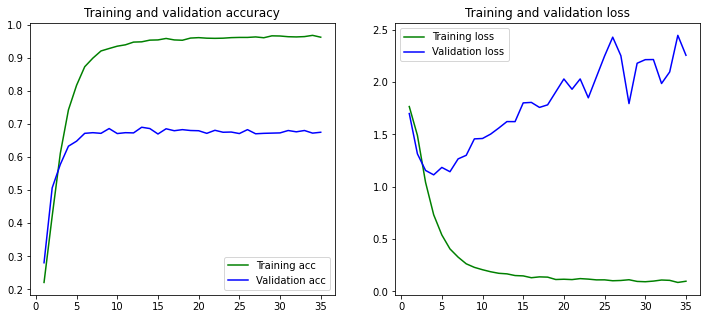

In [22]:
PlotGraph(history)

In [23]:
print(f"Best Accuracy Achieved by Model: {max(history.history['val_accuracy'])}")

Best Accuracy Achieved by Model: 0.6898817420005798


In [24]:
predict = model.predict(TEST)
predict_class = np.argmax(predict, axis=1)
predict_class = np.array(predict_class)
predict_class

array([3, 1, 5, ..., 1, 2, 0], dtype=int64)

In [25]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_df["labels"], predict_class)
cm

array([[170,  25,  12,  28,   9,  24],
       [ 14, 160,   4,  17,  17,  12],
       [ 15,   9, 215,  12,  11,  13],
       [ 16,   8,   7, 191,  10,  30],
       [ 48,  31,  18,  24, 112,  31],
       [ 12,  10,   4,  16,   8, 179]], dtype=int64)

<AxesSubplot:>

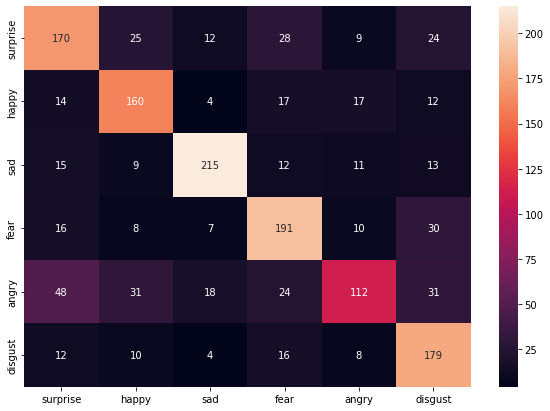

In [26]:
df_cm = pd.DataFrame(cm, index=["surprise","happy","sad", "fear", "angry","disgust"], columns=["surprise","happy","sad", "fear", "angry","disgust"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm,annot=True, fmt ="d")

In [27]:
from sklearn.metrics import classification_report

print(classification_report(test_df["labels"], predict_class, target_names =["anger", "fear", "joy", "disgust", "sadness", "surprise"]))

              precision    recall  f1-score   support

       anger       0.62      0.63      0.63       268
        fear       0.66      0.71      0.69       224
         joy       0.83      0.78      0.80       275
     disgust       0.66      0.73      0.69       262
     sadness       0.67      0.42      0.52       264
    surprise       0.62      0.78      0.69       229

    accuracy                           0.67      1522
   macro avg       0.68      0.68      0.67      1522
weighted avg       0.68      0.67      0.67      1522

